In [4]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set('talk')
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'large',
          'figure.figsize': (16, 9),
         'axes.labelsize': 'medium',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
plt.rcParams.update(params)
import json
from pandas.io.json import json_normalize

In [2]:
with open('gpu_win_pc_offload.json') as json_file:
    data = json.load(json_file)

In [3]:
df = pd.DataFrame()
df = json_normalize(data,)

top-5 accuracy

In [8]:
df.loc[(df['index_top5'] != -1)].groupby('exit').count()['index_top5'] / 5000

exit
0    0.7896
1    0.9180
2    0.9468
3    0.9654
Name: index_top5, dtype: float64

In [9]:
df.loc[(df['correct']==False) & (df['index_top5'] != -1)]

,sample,exit,prediction,scores,target,overall time,prediction time,tx time,rx time,preprocess time,correct,index_top5
37,9,1,"[92, 13, 77, 0, 36]","[0.5218490362167358, 0.23613707721233368, 0.12...",0,76.8504,12.0652,6.6571,83.3850,1.1968,False,3
38,9,2,"[92, 0, 36, 13, 65]","[0.7374882698059082, 0.18548332154750824, 0.05...",0,93.3645,22.8457,6.6571,83.3850,1.1968,False,1
44,11,0,"[13, 0, 77, 36, 92]","[0.42317724227905273, 0.2915263772010803, 0.09...",0,72.8046,5.2974,6.9261,82.3268,1.3143,False,1
68,17,0,"[92, 0, 65, 36, 70]","[0.9107751250267029, 0.06875943392515182, 0.00...",0,78.2459,6.6837,6.8314,92.6833,1.3634,False,1
73,18,1,"[54, 83, 0, 23, 62]","[0.7251542210578918, 0.12804347276687622, 0.09...",0,76.2165,12.1076,6.4585,71.4170,1.2687,False,2
...,...,...,...,...,...,...,...,...,...,...,...,...
19977,4994,1,"[94, 99, 40, 49, 96]","[0.7472103238105774, 0.11938763409852982, 0.07...",99,61.4499,12.2950,3.1405,1442.3093,1.3480,False,1
19985,4996,1,"[72, 48, 99, 54, 74]","[0.5930332541465759, 0.10434065759181976, 0.06...",99,71.5122,12.4435,5.2100,1643.6984,1.3505,False,2
19988,4997,0,"[94, 46, 72, 99, 74]","[0.2848220765590668, 0.20610013604164124, 0.17...",99,65.4435,5.2748,3.3802,1412.9024,1.3497,False,3
19989,4997,1,"[55, 72, 99, 46, 74]","[0.5687741637229919, 0.259137362241745, 0.0820...",99,66.7138,12.2199,3.3802,1412.9024,1.3497,False,2


In [9]:
def MultiHotEncode(_labels, _scores, n_classes=100):
    '''Return topk labels and scores as multihot encoded vector. 
    Missing labels are padded with minus one.
    Missing scores are padded with zeros'''
    retLabels, retScores = [], []
    
    # dimensionality check
    if not len(_labels.shape) == len(_scores.shape):
        raise Exception('Dimensionality must match')
    
    # if only one dimensio
    if len(_labels.shape) == 1:
        multihotlabels = np.negative(np.ones(n_classes))
        multihotscores = np.zeros(n_classes)
        for l, s in zip(_labels, _scores):
            #print(l)
            multihotlabels[l] = l
            multihotscores[l] = s
        retLabels.append(multihotlabels)
        retScores.append(multihotscores)
    
    # mulitple dimension
    else:  
        for n in range(_labels.shape[0]):
            multihotlabels = np.negative(np.ones(n_classes))
            multihotscores = np.zeros(n_classes)
            for l, s in zip(_labels[n], _scores[n]):
                #print(l)
                multihotlabels[l] = l
                multihotscores[l] = s
            retLabels.append(multihotlabels)
            retScores.append(multihotscores)
    return retLabels, retScores

def AddMultiHotScores(_labels, _scores, weights = None):
    
    _scores = np.array(_scores)
    
    if weights:
        weights = np.array(weights)[:_scores.shape[0]]
        _scores = np.multiply(_scores, weights[:, None])

    #print(_labels, _scores)
    _labels = np.array(_labels)
    
    _scores = (_scores.sum(axis=0))
    

    labellist = []
    for label in _labels:
        for element in label:
            if element != -1:
                if element not in labellist:
                    labellist.append(element.astype(int))
    labellist.sort()
    return labellist, _scores[_scores != -0]


def MaxMultiHotScores(_labels, _scores):
    _labels = np.array(_labels)
    _scores = np.array(_scores).max(axis=0)

    labellist = []
    for label in _labels:
        for element in label:
            if element != -1:
                if element not in labellist:
                    labellist.append(element.astype(int))
    labellist.sort()
    return labellist, _scores[_scores != -0]

def Confidence(_labels, _scores, selection='additive', weights = None, n_classes=None):
    '''
    Return the confidence score prediction as an addition of prediction or max selection.
    If weights are given each prediction score are weighted accordingly. 
    If sparse prediction vector are provided and prediction labels are not consistent,
    expansion to full dimensionality is performed.
    '''
    
    # transform to numpy arrays
    _labels = np.array(_labels)
    _scores = np.array(_scores)
    
    # weight prediction by multiplying weight vector
    if weights:
        weights = np.array(weights)[:_scores.shape[0]]
        _scores = np.multiply(_scores, weights[:, None])

    # if sparse labels does not match transformation to original class space is required
    if n_classes and n_classes != _labels.shape[0]:
            MultiHotEncode(_labels, _scores, n_classes)
    
    # Sum across predtion or take max
    if selection == 'additive':
        _scores = _scores.sum(axis=0)
    elif selection == 'max':
        _scores = _scores.max(axis=0)
    else:
        raise Exception("Selection is required. Either 'additive' or 'max'")
    
    # create list of labes from prediction with no duplicates
    labellist = []
    for label in _labels:
        for element in label:
            if element != -1:
                if element not in labellist:
                    labellist.append(element.astype(int))
                    
    # sort list to match scores
    labellist.sort()
    
    # find best prediction
    _scores = _scores[_scores != -0]
    idx = np.argmax(_scores)
    
    return labellist[idx], _scores[idx]

def ScoreMargin(_labels, _scores, selection='additive', weights = None):
    '''
    Return the score-margin prediction as a addition of provided predictions or a max selection.
    If weights are given each prediction score are weighted accordingly. 
    '''
    
    # transform to numpy arrays
    _labels = np.array(_labels)
    _scores = np.array(_scores)
    
    # weight prediction by multiplying weight vector
    if weights:
        weights = np.array(weights)[:_scores.shape[0]]
        _scores = np.multiply(_scores, weights[:, None])

    # create list of labels from prediction with no duplicates and corresponding score list
    labellist = []
    scorelist = []
    for label, score in zip(_labels,_scores):
        _score_margin = (score[0] - score[1])
        if selection == 'additive':
            if label[0] not in labellist:
                labellist.append(label[0].astype(int))
                scorelist.append(_score_margin)
            else:
                idx = labellist.index(label[0])
                scorelist[idx] += _score_margin
        if selection == 'max':
            if label[0] not in labellist:
                labellist.append(label[0].astype(int))
                scorelist.append(_score_margin)

    # find best prediction
    idx = np.argmax(np.array(scorelist))
    return labellist[idx], scorelist[idx]

In [28]:
s = 0
labels, scores = np.array(df.loc[df['sample']==s].prediction.tolist()), np.array(df.loc[df['sample']==s].scores.tolist())
target = df.loc[df['sample']==s].target.tolist()[0]
print('Input\nlabels\n {}\n scores\n {}'.format(labels, np.around(scores,3)))
sm = Confidence(labels, scores, 'max', n_classes=100)
#labels, scores = MultiHotEncode(labels, scores)

maximum = Confidence(labels, scores, selection='max')
addition = Confidence(labels, scores)
print('Output Max:\nlabels\n {}\n scores\n {}'.format(maximum[0], np.around(maximum[1],3)))
print('Output Add:\nlabels\n {}\n scores\n {}'.format(addition[0], np.around(addition[1],3)))

print(target)

Input
labels
 [[ 0 13 36 92 97]
 [ 0 92 65 60 95]
 [ 0 92 65 13 36]
 [ 0 92 65 13 36]]
 scores
 [[0.55  0.162 0.147 0.066 0.023]
 [0.772 0.187 0.035 0.002 0.002]
 [0.972 0.025 0.002 0.001 0.   ]
 [1.    0.    0.    0.    0.   ]]
Output Max:
labels
 0
 scores
 1.0
Output Add:
labels
 0
 scores
 3.293
0


In [27]:
Confidence(labels, scores, selection='additive')
Confidence(labels, scores, selection='additive', weights=[1, 2, 3, 4])

(0, 9.996257603168488)

In [21]:
post_prediction = pd.DataFrame()
for delay_threshold in np.arange(50, 60, 10):
    n = 0
    correct = 0
    conventional = 0
    maximum = 0
    addition = 0
    addition_w = 0
    incorrect = 0
    missed = 0
    sm_additive = 0
    sm_additive_w = 0
    sm_max = 0
    which_exits = np.zeros(4)
    for i, data in df.groupby(['sample']):
        #print(data.prediction.tolist())
        exits = len([time for time in data['overall time'].tolist() if time < 120]) 
        #print(exits)
        if exits != 0:
            n += 1
            which_exits[exits-1] += 1
            labels, scores = np.array(data.prediction.tolist()[:exits]), np.array(data.scores.tolist()[:exits])
            #print(labels, scores)
            score_additive_w = ScoreMargin(labels, scores, 'additive', weights=[1, 1.5, 2, 2])
            score_additive = ScoreMargin(labels, scores, 'additive', weights=[1,1,1,1])
            score_max = ScoreMargin(labels, scores, 'max')
            addtest = Confidence(labels, scores, selection='additive')
            addtest_w = Confidence(labels, scores, selection='additive', weights=[1, 2, 3, 4])
            labels, scores = MultiHotEncode(labels,scores)
            
            maxtest = Confidence(labels, scores, selection='max')
            target = data.target.tolist()
            print(add_test, addtest_w)
            addition_w +=  (addtest_w[0]== target[0])
            addition += (addtest[0]==target[0])
            maximum += (maxtest[0] == target[0])
            conventional += (target[0] == data.prediction.tolist()[exits-1][0])
            sm_additive_w += (target[0] == score_additive_w[0])
            sm_additive += (target[0] == score_additive[0])
            sm_max += (target[0]==score_max[0])
        else:
            missed +=1

    if n != 0:
        post_prediction = post_prediction.append({
            'Delay Threshold': delay_threshold,
            'Exit' : which_exits,
            'N': n+missed,
            'missed': missed,
            'latest': conventional / n,
            'confidence (max)' : maximum / n,
            'confidence (add)' : addition / n,
            'confidence (add,weighted)' : addition_w / n,
            'score-margin (max)' : sm_max / n,
            'score_margin (add)' : sm_additive / n,
            'score-margin (add,weighted)' : sm_additive_w / n
        }, ignore_index = True)
    else:
        post_prediction = post_prediction.append({
            'Delay Threshold': delay_threshold,
            'N': n+missed
        }, ignore_index = True)

##print('total number of samples predicted: {}/{}'.format(n, n+missed))
#print('conventional {}\naddition {}\nmaximum {}\nmissed {}'.format(conventional / n, addition /n, maximum / n, missed  /(n+missed)))
#print('score-margin (add): {}\nscore-margin (add, weighted) {} \nscore-margin (max) {}'.format(sm_additive /n, sm_additive_w /n, sm_max /n))

(15, 0.2605234682559967) (0, 8.8056221306324)
(15, 0.2605234682559967) (0, 5.749084293842316)
(15, 0.2605234682559967) (0, 5.771713674068451)
(15, 0.2605234682559967) (0, 9.824538707733154)
(15, 0.2605234682559967) (0, 9.93236356973648)
(15, 0.2605234682559967) (0, 5.996288597583771)
(15, 0.2605234682559967) (0, 9.99873036146164)
(15, 0.2605234682559967) (0, 4.453611820936203)
(15, 0.2605234682559967) (0, 3.49867781996727)
(15, 0.2605234682559967) (0, 5.998887836933136)
(15, 0.2605234682559967) (0, 5.421318590641022)
(15, 0.2605234682559967) (0, 5.999470233917236)
(15, 0.2605234682559967) (0, 9.884321808815002)
(15, 0.2605234682559967) (0, 5.3130203783512115)
(15, 0.2605234682559967) (0, 5.410514444112778)
(15, 0.2605234682559967) (0, 5.65718150138855)
(15, 0.2605234682559967) (0, 8.86821436882019)
(15, 0.2605234682559967) (0, 5.096818506717682)
(15, 0.2605234682559967) (0, 8.927089974284172)
(15, 0.2605234682559967) (0, 5.985287964344025)
(15, 0.2605234682559967) (0, 7.403219848871231

(15, 0.2605234682559967) (3, 8.62057214975357)
(15, 0.2605234682559967) (3, 8.97915306687355)
(15, 0.2605234682559967) (4, 9.932317554950714)
(15, 0.2605234682559967) (4, 5.409071356058121)
(15, 0.2605234682559967) (4, 5.222676694393158)
(15, 0.2605234682559967) (4, 5.9265947341918945)
(15, 0.2605234682559967) (4, 0.7627173066139221)
(15, 0.2605234682559967) (3, 5.995787680149078)
(15, 0.2605234682559967) (4, 0.6510462164878845)
(15, 0.2605234682559967) (4, 2.836370825767517)
(15, 0.2605234682559967) (4, 0.34129977226257324)
(15, 0.2605234682559967) (4, 0.9369166493415833)
(15, 0.2605234682559967) (4, 1.34796804189682)
(15, 0.2605234682559967) (4, 9.924390435218811)
(15, 0.2605234682559967) (4, 5.994348883628845)
(15, 0.2605234682559967) (4, 5.338031440973282)
(15, 0.2605234682559967) (4, 9.468763768672943)
(15, 0.2605234682559967) (4, 9.970134198665619)
(15, 0.2605234682559967) (4, 9.83073091506958)
(15, 0.2605234682559967) (3, 9.785428822040558)
(15, 0.2605234682559967) (4, 9.2511199

(15, 0.2605234682559967) (7, 5.809853911399841)
(15, 0.2605234682559967) (4, 5.349334686994553)
(15, 0.2605234682559967) (7, 5.735973238945007)
(15, 0.2605234682559967) (7, 9.247425556182861)
(15, 0.2605234682559967) (7, 9.874939620494843)
(15, 0.2605234682559967) (7, 9.345487385988235)
(15, 0.2605234682559967) (2, 7.253144234418869)
(15, 0.2605234682559967) (7, 9.004344522953033)
(15, 0.2605234682559967) (2, 9.031701162457466)
(15, 0.2605234682559967) (7, 9.468791365623474)
(15, 0.2605234682559967) (3, 9.254154533147812)
(15, 0.2605234682559967) (2, 9.959455788135529)
(15, 0.2605234682559967) (7, 7.810345351696014)
(15, 0.2605234682559967) (2, 5.855133235454559)
(15, 0.2605234682559967) (7, 5.590522825717926)
(15, 0.2605234682559967) (8, 9.507207036018372)
(15, 0.2605234682559967) (8, 9.035384804010391)
(15, 0.2605234682559967) (3, 8.60066694021225)
(15, 0.2605234682559967) (5, 8.71379454433918)
(15, 0.2605234682559967) (3, 4.853727839887142)
(15, 0.2605234682559967) (8, 9.69462084770

(15, 0.2605234682559967) (3, 7.980401426553726)
(15, 0.2605234682559967) (3, 4.9172468185424805)
(15, 0.2605234682559967) (4, 5.192532896995544)
(15, 0.2605234682559967) (4, 5.818464934825897)
(15, 0.2605234682559967) (4, 5.744150876998901)
(15, 0.2605234682559967) (4, 2.4355763643980026)
(15, 0.2605234682559967) (2, 9.968002200126648)
(15, 0.2605234682559967) (2, 5.915564656257629)
(15, 0.2605234682559967) (0, 9.29848563671112)
(15, 0.2605234682559967) (2, 9.493168830871582)
(15, 0.2605234682559967) (4, 9.89775013923645)
(15, 0.2605234682559967) (3, 4.216688454151154)
(15, 0.2605234682559967) (4, 5.399852514266968)
(15, 0.2605234682559967) (3, 9.921409606933594)
(15, 0.2605234682559967) (3, 5.138850092887878)
(15, 0.2605234682559967) (2, 8.288553416728973)
(15, 0.2605234682559967) (12, 5.983669102191925)
(15, 0.2605234682559967) (5, 9.691982567310333)
(15, 0.2605234682559967) (12, 5.999182879924774)
(15, 0.2605234682559967) (12, 5.768854558467865)
(15, 0.2605234682559967) (12, 9.99868

(15, 0.2605234682559967) (2, 5.814678132534027)
(15, 0.2605234682559967) (3, 8.081917315721512)
(15, 0.2605234682559967) (4, 6.536268159747124)
(15, 0.2605234682559967) (2, 6.397686749696732)
(15, 0.2605234682559967) (4, 7.486015319824219)
(15, 0.2605234682559967) (3, 7.965337559580803)
(15, 0.2605234682559967) (6, 9.02996701002121)
(15, 0.2605234682559967) (15, 6.986794292926788)
(15, 0.2605234682559967) (3, 3.920947790145874)
(15, 0.2605234682559967) (4, 9.754526376724243)
(15, 0.2605234682559967) (3, 5.80927962064743)
(15, 0.2605234682559967) (3, 8.158542782068253)
(15, 0.2605234682559967) (3, 4.567679464817047)
(15, 0.2605234682559967) (2, 8.984202541410923)
(15, 0.2605234682559967) (2, 8.8905588388443)
(15, 0.2605234682559967) (2, 8.265121638774872)
(15, 0.2605234682559967) (3, 4.836474657058716)
(15, 0.2605234682559967) (15, 7.383872151374817)
(15, 0.2605234682559967) (2, 6.648426532745361)
(15, 0.2605234682559967) (4, 3.080395847558975)
(15, 0.2605234682559967) (2, 8.97991102933

(15, 0.2605234682559967) (3, 8.057435184717178)
(15, 0.2605234682559967) (2, 9.593207001686096)
(15, 0.2605234682559967) (2, 1.9994096159934998)
(15, 0.2605234682559967) (2, 9.149411663413048)
(15, 0.2605234682559967) (2, 9.9610396027565)
(15, 0.2605234682559967) (2, 9.274876564741135)
(15, 0.2605234682559967) (2, 9.244837701320648)
(15, 0.2605234682559967) (3, 9.27638664841652)
(15, 0.2605234682559967) (2, 3.989155814051628)
(15, 0.2605234682559967) (2, 8.970400333404541)
(15, 0.2605234682559967) (2, 8.95310154557228)
(15, 0.2605234682559967) (2, 5.295913100242615)
(15, 0.2605234682559967) (2, 9.323400676250458)
(15, 0.2605234682559967) (2, 5.874691605567932)
(15, 0.2605234682559967) (17, 5.725396037101746)
(15, 0.2605234682559967) (2, 8.92886757850647)
(15, 0.2605234682559967) (2, 5.498767584562302)
(15, 0.2605234682559967) (14, 9.913143873214722)
(15, 0.2605234682559967) (18, 5.670850515365601)
(15, 0.2605234682559967) (5, 9.737372994422913)
(15, 0.2605234682559967) (4, 9.3834395408

(15, 0.2605234682559967) (1, 9.00289997458458)
(15, 0.2605234682559967) (2, 8.300504267215729)
(15, 0.2605234682559967) (1, 4.1498637944459915)
(15, 0.2605234682559967) (1, 5.536461889743805)
(15, 0.2605234682559967) (6, 8.553536534309387)
(15, 0.2605234682559967) (1, 8.5606609582901)
(15, 0.2605234682559967) (6, 9.32222855091095)
(15, 0.2605234682559967) (1, 8.74106079339981)
(15, 0.2605234682559967) (1, 8.173424661159515)
(15, 0.2605234682559967) (6, 9.319378733634949)
(15, 0.2605234682559967) (12, 9.672981023788452)
(15, 0.2605234682559967) (5, 7.896122753620148)
(15, 0.2605234682559967) (1, 8.802728652954102)
(15, 0.2605234682559967) (2, 5.542179837822914)
(15, 0.2605234682559967) (12, 9.237793147563934)
(15, 0.2605234682559967) (12, 8.814466178417206)
(15, 0.2605234682559967) (1, 9.188376128673553)
(15, 0.2605234682559967) (12, 8.77021835744381)
(15, 0.2605234682559967) (12, 8.94197991490364)
(15, 0.2605234682559967) (1, 9.646342992782593)
(15, 0.2605234682559967) (24, 8.540744185

(15, 0.2605234682559967) (3, 9.041816651821136)
(15, 0.2605234682559967) (3, 9.418591976165771)
(15, 0.2605234682559967) (3, 8.790618941187859)
(15, 0.2605234682559967) (3, 9.458985805511475)
(15, 0.2605234682559967) (3, 9.280448496341705)
(15, 0.2605234682559967) (3, 6.434638425707817)
(15, 0.2605234682559967) (3, 8.588574677705765)
(15, 0.2605234682559967) (3, 7.355509847402573)
(15, 0.2605234682559967) (3, 9.572519481182098)
(15, 0.2605234682559967) (3, 9.406237840652466)
(15, 0.2605234682559967) (3, 9.467987775802612)
(15, 0.2605234682559967) (3, 8.558063089847565)
(15, 0.2605234682559967) (3, 9.43760359287262)
(15, 0.2605234682559967) (3, 9.170394539833069)
(15, 0.2605234682559967) (4, 9.535876154899597)
(15, 0.2605234682559967) (11, 9.549988389015198)
(15, 0.2605234682559967) (3, 9.278192669153214)
(15, 0.2605234682559967) (3, 8.58309656381607)
(15, 0.2605234682559967) (3, 6.441524118185043)
(15, 0.2605234682559967) (3, 5.203670710325241)
(15, 0.2605234682559967) (3, 9.3012216091

(15, 0.2605234682559967) (3, 8.92153088748455)
(15, 0.2605234682559967) (3, 9.891204476356506)
(15, 0.2605234682559967) (3, 9.827793717384338)
(15, 0.2605234682559967) (20, 9.450831949710846)
(15, 0.2605234682559967) (4, 8.270510375499725)
(15, 0.2605234682559967) (4, 7.142172500491142)
(15, 0.2605234682559967) (4, 9.637583136558533)
(15, 0.2605234682559967) (3, 8.782112449407578)
(15, 0.2605234682559967) (3, 8.155364602804184)
(15, 0.2605234682559967) (4, 9.959541022777557)
(15, 0.2605234682559967) (5, 9.338153600692749)
(15, 0.2605234682559967) (4, 9.131352633237839)
(15, 0.2605234682559967) (5, 6.303396463394165)
(15, 0.2605234682559967) (5, 7.956308037042618)
(15, 0.2605234682559967) (3, 8.308176040649414)
(15, 0.2605234682559967) (3, 9.843693614006042)
(15, 0.2605234682559967) (3, 9.820016026496887)
(15, 0.2605234682559967) (4, 9.437025547027588)
(15, 0.2605234682559967) (4, 9.713261663913727)
(15, 0.2605234682559967) (2, 8.448741734027863)
(15, 0.2605234682559967) (3, 9.841590166

(15, 0.2605234682559967) (4, 9.123194992542267)
(15, 0.2605234682559967) (3, 9.840307474136353)
(15, 0.2605234682559967) (4, 9.961476743221283)
(15, 0.2605234682559967) (3, 9.877581477165222)
(15, 0.2605234682559967) (0, 9.851918637752533)
(15, 0.2605234682559967) (13, 9.676640748977661)
(15, 0.2605234682559967) (9, 9.871022522449493)
(15, 0.2605234682559967) (5, 9.512034893035889)
(15, 0.2605234682559967) (4, 9.5962632894516)
(15, 0.2605234682559967) (3, 9.895105004310608)
(15, 0.2605234682559967) (13, 9.985368251800537)
(15, 0.2605234682559967) (3, 9.750421702861786)
(15, 0.2605234682559967) (4, 9.458671569824219)
(15, 0.2605234682559967) (13, 9.832434117794037)
(15, 0.2605234682559967) (3, 9.54298198223114)
(15, 0.2605234682559967) (0, 8.931760668754578)
(15, 0.2605234682559967) (0, 9.577500700950623)
(15, 0.2605234682559967) (4, 9.990305662155151)
(15, 0.2605234682559967) (3, 5.529819518327713)
(15, 0.2605234682559967) (13, 9.378949642181396)
(15, 0.2605234682559967) (8, 9.20922791

(15, 0.2605234682559967) (2, 9.201074078679085)
(15, 0.2605234682559967) (2, 9.20592188835144)
(15, 0.2605234682559967) (2, 9.535758912563324)
(15, 0.2605234682559967) (1, 3.636146366596222)
(15, 0.2605234682559967) (2, 9.352908998727798)
(15, 0.2605234682559967) (6, 5.459405839443207)
(15, 0.2605234682559967) (17, 9.2799451649189)
(15, 0.2605234682559967) (9, 9.2696792781353)
(15, 0.2605234682559967) (2, 8.771819666028023)
(15, 0.2605234682559967) (2, 6.059239208698273)
(15, 0.2605234682559967) (24, 8.674587279558182)
(15, 0.2605234682559967) (3, 9.088274747133255)
(15, 0.2605234682559967) (1, 7.547457501292229)
(15, 0.2605234682559967) (24, 7.499015741050243)
(15, 0.2605234682559967) (2, 6.499789476394653)
(15, 0.2605234682559967) (6, 9.16788250207901)
(15, 0.2605234682559967) (9, 9.306269496679306)
(15, 0.2605234682559967) (3, 6.356074959039688)
(15, 0.2605234682559967) (3, 6.511777937412262)
(15, 0.2605234682559967) (2, 9.094064474105835)
(15, 0.2605234682559967) (1, 8.782492101192

(15, 0.2605234682559967) (1, 9.318709939718246)
(15, 0.2605234682559967) (5, 9.442818760871887)
(15, 0.2605234682559967) (18, 4.127206981182098)
(15, 0.2605234682559967) (3, 8.248668864369392)
(15, 0.2605234682559967) (5, 9.469144821166992)
(15, 0.2605234682559967) (2, 9.188024550676346)
(15, 0.2605234682559967) (1, 8.556535333395004)
(15, 0.2605234682559967) (7, 9.167520523071289)
(15, 0.2605234682559967) (5, 7.678948938846588)
(15, 0.2605234682559967) (3, 9.516411304473877)
(15, 0.2605234682559967) (13, 5.35845810174942)
(15, 0.2605234682559967) (15, 4.236840933561325)
(15, 0.2605234682559967) (2, 8.031821638345718)
(15, 0.2605234682559967) (3, 8.96280974149704)
(15, 0.2605234682559967) (2, 8.676790624856949)
(15, 0.2605234682559967) (11, 8.951623067259789)
(15, 0.2605234682559967) (2, 8.938773691654205)
(15, 0.2605234682559967) (3, 9.174063071608543)
(15, 0.2605234682559967) (3, 5.350774347782135)
(15, 0.2605234682559967) (15, 8.481032148003578)
(15, 0.2605234682559967) (3, 9.257458

(15, 0.2605234682559967) (1, 8.240501940250397)
(15, 0.2605234682559967) (24, 2.937905967235565)
(15, 0.2605234682559967) (23, 9.677130937576294)
(15, 0.2605234682559967) (23, 9.952140808105469)
(15, 0.2605234682559967) (1, 9.997189819812775)
(15, 0.2605234682559967) (23, 9.980335295200348)
(15, 0.2605234682559967) (1, 1.6286637037992477)
(15, 0.2605234682559967) (23, 9.383236199617386)
(15, 0.2605234682559967) (3, 5.231914401054382)
(15, 0.2605234682559967) (0, 7.249357223510742)
(15, 0.2605234682559967) (9, 5.7252713441848755)
(15, 0.2605234682559967) (24, 9.629838049411774)
(15, 0.2605234682559967) (1, 5.978974223136902)
(15, 0.2605234682559967) (7, 6.389387458562851)
(15, 0.2605234682559967) (7, 9.982687711715698)
(15, 0.2605234682559967) (1, 8.775880500674248)
(15, 0.2605234682559967) (24, 9.990624129772186)
(15, 0.2605234682559967) (3, 4.9051496386528015)
(15, 0.2605234682559967) (1, 9.766481876373291)
(15, 0.2605234682559967) (3, 6.836465090513229)
(15, 0.2605234682559967) (22, 

(15, 0.2605234682559967) (4, 9.935934901237488)
(15, 0.2605234682559967) (4, 9.404028058052063)
(15, 0.2605234682559967) (4, 8.606617331504822)
(15, 0.2605234682559967) (4, 9.64064234495163)
(15, 0.2605234682559967) (4, 5.4304179251194)
(15, 0.2605234682559967) (4, 9.625565528869629)
(15, 0.2605234682559967) (9, 4.204829454421997)
(15, 0.2605234682559967) (1, 8.80404543876648)
(15, 0.2605234682559967) (12, 8.949066281318665)
(15, 0.2605234682559967) (24, 9.549420952796936)
(15, 0.2605234682559967) (37, 5.302262485027313)
(15, 0.2605234682559967) (18, 9.018408983945847)
(15, 0.2605234682559967) (3, 9.382651001214981)
(15, 0.2605234682559967) (2, 5.894135281443596)
(15, 0.2605234682559967) (1, 5.617572948336601)
(15, 0.2605234682559967) (1, 6.4065210819244385)
(15, 0.2605234682559967) (12, 5.281811326742172)
(15, 0.2605234682559967) (2, 8.50275444984436)
(15, 0.2605234682559967) (52, 3.6788751780986786)
(15, 0.2605234682559967) (3, 9.281952500343323)
(15, 0.2605234682559967) (3, 8.026357

(15, 0.2605234682559967) (17, 9.596346259117126)
(15, 0.2605234682559967) (17, 9.46562373638153)
(15, 0.2605234682559967) (17, 5.942068696022034)
(15, 0.2605234682559967) (17, 9.981581449508667)
(15, 0.2605234682559967) (17, 9.891578257083893)
(15, 0.2605234682559967) (6, 9.600531578063965)
(15, 0.2605234682559967) (1, 9.19965660572052)
(15, 0.2605234682559967) (7, 9.956219673156738)
(15, 0.2605234682559967) (17, 9.41243639588356)
(15, 0.2605234682559967) (0, 5.958676606416702)
(15, 0.2605234682559967) (2, 8.11925595998764)
(15, 0.2605234682559967) (17, 9.969886541366577)
(15, 0.2605234682559967) (0, 9.847407341003418)
(15, 0.2605234682559967) (29, 9.928370952606201)
(15, 0.2605234682559967) (17, 9.770947873592377)
(15, 0.2605234682559967) (6, 9.993255019187927)
(15, 0.2605234682559967) (0, 9.99100524187088)
(15, 0.2605234682559967) (29, 9.812700986862183)
(15, 0.2605234682559967) (17, 5.8026620745658875)
(15, 0.2605234682559967) (2, 7.443484425544739)
(15, 0.2605234682559967) (6, 5.50

(15, 0.2605234682559967) (13, 9.449021399021149)
(15, 0.2605234682559967) (0, 9.983012557029724)
(15, 0.2605234682559967) (0, 9.996391713619232)
(15, 0.2605234682559967) (0, 9.898421585559845)
(15, 0.2605234682559967) (0, 9.978832244873047)
(15, 0.2605234682559967) (14, 9.933283627033234)
(15, 0.2605234682559967) (17, 9.917065441608429)
(15, 0.2605234682559967) (10, 8.798346042633057)
(15, 0.2605234682559967) (0, 9.949184894561768)
(15, 0.2605234682559967) (0, 5.292130172252655)
(15, 0.2605234682559967) (0, 5.351389646530151)
(15, 0.2605234682559967) (0, 4.573295027017593)
(15, 0.2605234682559967) (0, 9.452784299850464)
(15, 0.2605234682559967) (0, 8.92786192893982)
(15, 0.2605234682559967) (20, 9.837450623512268)
(15, 0.2605234682559967) (0, 9.16396889090538)
(15, 0.2605234682559967) (0, 9.28438287973404)
(15, 0.2605234682559967) (4, 9.007990926504135)
(15, 0.2605234682559967) (20, 4.354262977838516)
(15, 0.2605234682559967) (20, 9.932104110717773)
(15, 0.2605234682559967) (0, 5.40417

(15, 0.2605234682559967) (1, 9.269225239753723)
(15, 0.2605234682559967) (1, 7.782433569431305)
(15, 0.2605234682559967) (1, 6.858899772167206)
(15, 0.2605234682559967) (1, 7.640163332223892)
(15, 0.2605234682559967) (1, 9.34087747335434)
(15, 0.2605234682559967) (2, 5.5440568923950195)
(15, 0.2605234682559967) (1, 8.291852474212646)
(15, 0.2605234682559967) (2, 8.712595224380493)
(15, 0.2605234682559967) (1, 9.13240447640419)
(15, 0.2605234682559967) (7, 7.678143173456192)
(15, 0.2605234682559967) (1, 8.349220603704453)
(15, 0.2605234682559967) (1, 9.078077584505081)
(15, 0.2605234682559967) (1, 5.572893798351288)
(15, 0.2605234682559967) (1, 9.258513867855072)
(15, 0.2605234682559967) (1, 9.317999690771103)
(15, 0.2605234682559967) (1, 8.450837016105652)
(15, 0.2605234682559967) (1, 1.6375348716974258)
(15, 0.2605234682559967) (1, 5.533668339252472)
(15, 0.2605234682559967) (9, 7.673173516988754)
(15, 0.2605234682559967) (2, 5.987009763717651)
(15, 0.2605234682559967) (2, 7.352930188

(15, 0.2605234682559967) (2, 7.902341693639755)
(15, 0.2605234682559967) (1, 4.785538017749786)
(15, 0.2605234682559967) (6, 6.4286810755729675)
(15, 0.2605234682559967) (33, 9.238691329956055)
(15, 0.2605234682559967) (9, 9.072824537754059)
(15, 0.2605234682559967) (1, 9.693673312664032)
(15, 0.2605234682559967) (1, 9.32042771577835)
(15, 0.2605234682559967) (2, 7.8980366587638855)
(15, 0.2605234682559967) (6, 7.594463348388672)
(15, 0.2605234682559967) (2, 6.37335792183876)
(15, 0.2605234682559967) (33, 9.150366216897964)
(15, 0.2605234682559967) (1, 6.5863082110881805)
(15, 0.2605234682559967) (1, 4.436622351408005)
(15, 0.2605234682559967) (9, 8.218609616160393)
(15, 0.2605234682559967) (6, 6.195460617542267)
(15, 0.2605234682559967) (24, 9.07406410574913)
(15, 0.2605234682559967) (2, 9.915432810783386)
(15, 0.2605234682559967) (2, 9.43292686343193)
(15, 0.2605234682559967) (3, 9.89466941356659)
(15, 0.2605234682559967) (5, 8.352896898984909)
(15, 0.2605234682559967) (11, 3.9090229

(15, 0.2605234682559967) (2, 9.99620497226715)
(15, 0.2605234682559967) (9, 4.389648213982582)
(15, 0.2605234682559967) (1, 3.990850120782852)
(15, 0.2605234682559967) (16, 9.147516965866089)
(15, 0.2605234682559967) (1, 7.023404270410538)
(15, 0.2605234682559967) (2, 8.377399504184723)
(15, 0.2605234682559967) (2, 9.765024840831757)
(15, 0.2605234682559967) (0, 9.154354393482208)
(15, 0.2605234682559967) (2, 9.927374184131622)
(15, 0.2605234682559967) (37, 9.46480542421341)
(15, 0.2605234682559967) (2, 5.325263291597366)
(15, 0.2605234682559967) (2, 5.972362816333771)
(15, 0.2605234682559967) (25, 8.72401088476181)
(15, 0.2605234682559967) (2, 9.9976264834404)
(15, 0.2605234682559967) (14, 6.01788429915905)
(15, 0.2605234682559967) (1, 7.5176911652088165)
(15, 0.2605234682559967) (16, 6.446090459823608)
(15, 0.2605234682559967) (13, 7.033041894435883)
(15, 0.2605234682559967) (2, 9.916537523269653)
(15, 0.2605234682559967) (2, 6.267633959650993)
(15, 0.2605234682559967) (35, 8.2017782

(15, 0.2605234682559967) (1, 9.093053251504898)
(15, 0.2605234682559967) (1, 9.027868121862411)
(15, 0.2605234682559967) (2, 3.658799111843109)
(15, 0.2605234682559967) (14, 2.4694986790418625)
(15, 0.2605234682559967) (1, 9.06794685125351)
(15, 0.2605234682559967) (1, 7.629737585783005)
(15, 0.2605234682559967) (1, 6.799539215862751)
(15, 0.2605234682559967) (1, 9.282304406166077)
(15, 0.2605234682559967) (2, 3.944628268480301)
(15, 0.2605234682559967) (1, 8.189626395702362)
(15, 0.2605234682559967) (1, 9.13993601500988)
(15, 0.2605234682559967) (1, 3.8994275629520416)
(15, 0.2605234682559967) (1, 8.74276839196682)
(15, 0.2605234682559967) (2, 8.01814590394497)
(15, 0.2605234682559967) (1, 9.30979198217392)
(15, 0.2605234682559967) (37, 6.9274067133665085)
(15, 0.2605234682559967) (3, 8.387193262577057)
(15, 0.2605234682559967) (7, 5.623050630092621)
(15, 0.2605234682559967) (8, 9.213888257741928)
(15, 0.2605234682559967) (17, 5.650526523590088)
(15, 0.2605234682559967) (8, 9.01104980

(15, 0.2605234682559967) (1, 9.996092736721039)
(15, 0.2605234682559967) (8, 6.994939893484116)
(15, 0.2605234682559967) (1, 9.815924227237701)
(15, 0.2605234682559967) (1, 3.5122857987880707)
(15, 0.2605234682559967) (21, 9.729854822158813)
(15, 0.2605234682559967) (9, 9.987131118774414)
(15, 0.2605234682559967) (9, 9.476063072681427)
(15, 0.2605234682559967) (1, 9.995427072048187)
(15, 0.2605234682559967) (9, 8.42050787806511)
(15, 0.2605234682559967) (2, 9.503792226314545)
(15, 0.2605234682559967) (10, 9.663017988204956)
(15, 0.2605234682559967) (9, 5.986521124839783)
(15, 0.2605234682559967) (9, 3.6169278025627136)
(15, 0.2605234682559967) (2, 9.797493517398834)
(15, 0.2605234682559967) (6, 9.712661564350128)
(15, 0.2605234682559967) (6, 9.187619626522064)
(15, 0.2605234682559967) (1, 9.313294351100922)
(15, 0.2605234682559967) (1, 5.876678228378296)
(15, 0.2605234682559967) (21, 5.6397958397865295)
(15, 0.2605234682559967) (2, 9.765797972679138)
(15, 0.2605234682559967) (9, 9.1821

(15, 0.2605234682559967) (2, 8.76244142651558)
(15, 0.2605234682559967) (3, 5.809043288230896)
(15, 0.2605234682559967) (23, 9.099843740463257)
(15, 0.2605234682559967) (17, 9.467230319976807)
(15, 0.2605234682559967) (6, 9.901817381381989)
(15, 0.2605234682559967) (7, 7.492038369178772)
(15, 0.2605234682559967) (2, 9.055747330188751)
(15, 0.2605234682559967) (14, 7.893455684185028)
(15, 0.2605234682559967) (10, 9.982686638832092)
(15, 0.2605234682559967) (3, 7.992453873157501)
(15, 0.2605234682559967) (10, 9.610929250717163)
(15, 0.2605234682559967) (10, 9.58577585220337)
(15, 0.2605234682559967) (6, 4.270035594701767)
(15, 0.2605234682559967) (17, 8.420780539512634)
(15, 0.2605234682559967) (2, 8.50775545835495)
(15, 0.2605234682559967) (3, 7.49226176738739)
(15, 0.2605234682559967) (1, 8.297655522823334)
(15, 0.2605234682559967) (6, 6.688455641269684)
(15, 0.2605234682559967) (7, 5.480874329805374)
(15, 0.2605234682559967) (1, 8.766913458704948)
(15, 0.2605234682559967) (3, 6.783028

(15, 0.2605234682559967) (14, 7.018121302127838)
(15, 0.2605234682559967) (3, 8.577315032482147)
(15, 0.2605234682559967) (11, 7.780608087778091)
(15, 0.2605234682559967) (15, 7.740176439285278)
(15, 0.2605234682559967) (4, 0.19069279730319977)
(15, 0.2605234682559967) (2, 8.999514758586884)
(15, 0.2605234682559967) (8, 6.664491772651672)
(15, 0.2605234682559967) (15, 6.743218645453453)
(15, 0.2605234682559967) (5, 8.79684591293335)
(15, 0.2605234682559967) (15, 7.194719076156616)
(15, 0.2605234682559967) (33, 9.172905802726746)
(15, 0.2605234682559967) (6, 9.263140767812729)
(15, 0.2605234682559967) (7, 9.539144158363342)
(15, 0.2605234682559967) (6, 9.550354421138763)
(15, 0.2605234682559967) (15, 9.901895582675934)
(15, 0.2605234682559967) (6, 9.914714992046356)
(15, 0.2605234682559967) (26, 9.579570293426514)
(15, 0.2605234682559967) (6, 9.40989363193512)
(15, 0.2605234682559967) (26, 4.064437091350555)
(15, 0.2605234682559967) (6, 9.406520575284958)
(15, 0.2605234682559967) (24, 8

(15, 0.2605234682559967) (2, 6.372027724981308)
(15, 0.2605234682559967) (8, 9.389286637306213)
(15, 0.2605234682559967) (17, 9.81066232919693)
(15, 0.2605234682559967) (8, 8.62777116894722)
(15, 0.2605234682559967) (17, 7.897460401058197)
(15, 0.2605234682559967) (17, 8.643065959215164)
(15, 0.2605234682559967) (17, 9.850580155849457)
(15, 0.2605234682559967) (17, 5.017819315195084)
(15, 0.2605234682559967) (7, 9.474765658378601)
(15, 0.2605234682559967) (8, 7.542934894561768)
(15, 0.2605234682559967) (8, 8.86455649137497)
(15, 0.2605234682559967) (17, 9.468469023704529)
(15, 0.2605234682559967) (0, 7.866746246814728)
(15, 0.2605234682559967) (2, 9.002826511859894)
(15, 0.2605234682559967) (17, 9.801407635211945)
(15, 0.2605234682559967) (33, 6.804158240556717)
(15, 0.2605234682559967) (5, 9.996428906917572)
(15, 0.2605234682559967) (33, 8.570706158876419)
(15, 0.2605234682559967) (6, 9.925632059574127)
(15, 0.2605234682559967) (7, 4.593754857778549)
(15, 0.2605234682559967) (2, 9.738

(15, 0.2605234682559967) (0, 9.168956130743027)
(15, 0.2605234682559967) (5, 9.14613077044487)
(15, 0.2605234682559967) (0, 9.967174887657166)
(15, 0.2605234682559967) (0, 9.587203204631805)
(15, 0.2605234682559967) (0, 7.850212931632996)
(15, 0.2605234682559967) (2, 9.68565171957016)
(15, 0.2605234682559967) (5, 9.556475520133972)
(15, 0.2605234682559967) (0, 9.429378628730774)
(15, 0.2605234682559967) (4, 9.429520606994629)
(15, 0.2605234682559967) (13, 8.544933557510376)
(15, 0.2605234682559967) (2, 5.051977977156639)
(15, 0.2605234682559967) (0, 9.485959887504578)
(15, 0.2605234682559967) (0, 9.331626206636429)
(15, 0.2605234682559967) (0, 9.51989996433258)
(15, 0.2605234682559967) (2, 5.813190817832947)
(15, 0.2605234682559967) (4, 8.965580821037292)
(15, 0.2605234682559967) (2, 9.162649109959602)
(15, 0.2605234682559967) (8, 6.664380341768265)
(15, 0.2605234682559967) (10, 7.790679290890694)
(15, 0.2605234682559967) (12, 9.37049874663353)
(15, 0.2605234682559967) (2, 9.8679298162

(15, 0.2605234682559967) (16, 9.178534418344498)
(15, 0.2605234682559967) (2, 7.7508524954319)
(15, 0.2605234682559967) (24, 9.182182997465134)
(15, 0.2605234682559967) (16, 9.115727335214615)
(15, 0.2605234682559967) (1, 6.60567232966423)
(15, 0.2605234682559967) (2, 3.697640985250473)
(15, 0.2605234682559967) (10, 9.558395683765411)
(15, 0.2605234682559967) (2, 8.446509152650833)
(15, 0.2605234682559967) (16, 9.456555783748627)
(15, 0.2605234682559967) (24, 8.459291622042656)
(15, 0.2605234682559967) (10, 5.439527198672295)
(15, 0.2605234682559967) (2, 9.205974131822586)
(15, 0.2605234682559967) (16, 9.600853741168976)
(15, 0.2605234682559967) (22, 6.237331032752991)
(15, 0.2605234682559967) (7, 6.652494624257088)
(15, 0.2605234682559967) (13, 9.507832288742065)
(15, 0.2605234682559967) (8, 8.891943827271461)
(15, 0.2605234682559967) (2, 9.347894877195358)
(15, 0.2605234682559967) (0, 9.439208209514618)
(15, 0.2605234682559967) (13, 9.286414504051208)
(15, 0.2605234682559967) (0, 9.9

In [23]:
post_prediction

,Delay Threshold,Exit,N,confidence (add),"confidence (add,weighted)",confidence (max),latest,missed,"score-margin (add,weighted)",score-margin (max),score_margin (add)
0,50.0,"[21.0, 5.0, 909.0, 4045.0]",5000.0,0.099197,0.099197,0.85241,0.860643,20.0,0.850402,0.81245,0.848193


In [ ]:
df.groupby('exit').mean()

In [43]:
exit_best = np.zeros(4)
exit_conf = np.zeros(4)
match = 0
for i, d in df.groupby('sample'):
    #tmp = d[np.argmax(d.scores.tolist()[0]):1]
    correct = d.correct.tolist()
    print(correct)
    scores = np.array(d.scores.tolist())
    print(scores[:,0])
    exit = np.argmax(d.scores.tolist())//4
    print(exit)
    # (d[exit:exit+1].exit.item())
    exit_best[exit] +=1


[True, True, True, True]
[0.55006939 0.77163953 0.97171986 0.99980468]
3
[True, True, True, True]
[0.34155884 0.73706514 0.99730873 0.99950171]
3
[True, True, True, True]
[0.9444961  0.90301847 0.99951708 0.99999261]
3
[True, True, True, True]
[0.77185553 0.99994016 0.99999261 0.99974889]
2
[True, True, True, True]
[0.82526052 0.99985564 0.9998709  0.99998856]
3
[True, True, True, True]
[0.93865377 0.99778783 0.99998116 0.99954766]
2
[True, True, True, True]
[0.99629563 0.99999952 0.99999797 0.99999225]
1
[True, True, True, True]
[0.99873763 0.99999654 0.99999988 1.        ]
3
[True, True, True, True]
[0.32639703 0.56378388 0.99988234 0.99998152]
3
[False, False, False, True]
[0.24251494 0.52184904 0.73748827 0.99717653]
3
[True, True, True, True]
[0.99889189 0.99999905 0.99999928 0.99999475]
2
[False, True, True, True]
[0.42317724 0.99985969 0.99947399 0.99999988]
3
[True, True, True, True]
[0.99965775 0.99992645 0.99998653 0.99997997]
2
[True, True, True, True]
[0.88649821 0.99955791

[True, True, True, True]
[0.35168773 0.7584492  0.89363062 0.9802264 ]
3
[False, True, True, True]
[0.35863075 0.98654824 0.99912173 0.99981552]
3
[True, True, True, True]
[0.39271021 0.92178798 0.98721969 0.96970731]
2
[True, True, True, True]
[0.65121269 0.99056047 0.99999011 0.99999666]
3
[False, True, True, True]
[0.19053617 0.95064431 0.87757027 0.99807799]
3
[False, True, True, True]
[0.27713493 0.99753702 0.99832076 0.99999833]
3
[False, True, True, False]
[0.24271075 0.89477581 0.5923714  0.48803651]
1
[False, False, False, False]
[0.3591308  0.82568389 0.62502563 0.50994927]
1
[True, True, True, True]
[0.31838319 0.96777982 0.7756533  0.95453387]
1
[False, True, True, True]
[0.29781625 0.46963096 0.99824488 0.84104675]
2
[True, True, True, True]
[0.30522814 0.99577647 0.99997735 0.99998724]
3
[False, True, True, True]
[0.66481715 0.99540567 0.9989723  0.999933  ]
3
[True, True, True, True]
[0.65660125 0.99993753 0.99999714 0.99999964]
3
[False, True, True, True]
[0.25669131 0.

[0.99955386 0.99990785 1.         0.99976593]
2
[False, True, True, True]
[0.52678001 0.99706072 0.60048896 0.48807621]
1
[False, True, True, True]
[0.19770306 0.99989629 0.99999988 0.99999535]
2
[False, False, False, True]
[0.56338429 0.75335777 0.72121269 0.98519033]
3
[False, True, True, True]
[0.79728502 0.71698213 0.9856776  0.99999893]
3
[True, True, True, True]
[0.82651126 0.99793148 1.         0.99999475]
2
[True, True, True, True]
[0.59565878 0.95084214 0.9999578  1.        ]
3
[True, True, True, True]
[0.28046438 0.69925612 0.99950278 0.99997282]
3
[True, True, True, True]
[0.98732239 1.         1.         0.9999944 ]
1
[True, True, True, True]
[0.80112863 0.99936539 1.         0.9999876 ]
2
[False, False, False, False]
[0.78405428 0.32952988 0.36179009 0.67002046]
0
[True, True, True, True]
[0.75541127 0.99999821 0.99999881 0.99999666]
2
[False, False, True, True]
[0.28010821 0.76662529 0.96715987 0.98988789]
3
[True, True, True, True]
[0.88637495 0.99938476 1.         0.999

[False, True, False, False]
[0.88885105 0.49240628 0.99921405 0.98956913]
2
[True, True, True, True]
[0.67326498 0.99799514 0.99972445 0.99951875]
2
[True, True, True, True]
[0.60447937 0.96722788 0.97075182 0.99986517]
3
[True, True, True, True]
[0.25447109 0.95856714 0.56086135 0.99607468]
3
[True, True, True, True]
[0.50447303 0.99182492 0.99999762 0.99948692]
2
[True, False, False, False]
[0.15125009 0.66285986 0.79974425 0.66669631]
2
[True, True, True, True]
[0.96493208 0.99952579 0.9999975  0.99826485]
2
[True, True, True, True]
[0.77981466 0.97590977 0.99999726 0.99986148]
2
[True, True, True, True]
[0.95746964 0.84355146 0.99999058 0.99999094]
3
[False, True, True, True]
[0.39114499 0.99672347 0.99999714 0.99999988]
3
[True, True, True, True]
[0.99184251 0.99999857 1.         0.99998987]
2
[True, True, True, True]
[0.99953282 0.99999833 1.         0.9999665 ]
2
[True, True, True, True]
[0.99669951 0.99998796 0.99999964 0.99999475]
2
[True, True, True, True]
[0.96251851 0.99999

[True, True, True, True]
[0.60405695 0.93044794 0.99940681 0.99903858]
2
[True, True, True, True]
[0.22401837 0.98436224 0.99999893 0.99999988]
3
[False, False, True, True]
[0.22948381 0.5402348  0.99985445 0.99998987]
3
[False, False, False, True]
[0.34607929 0.47845477 0.73266733 0.98522276]
3
[False, True, True, True]
[0.27582163 0.90473855 0.94667763 0.98659492]
3
[False, False, False, False]
[0.27113831 0.96513712 0.73312223 0.99086666]
3
[True, True, True, True]
[0.67136252 0.9963811  0.99995172 0.99918514]
2
[True, True, True, True]
[0.24400564 0.9325127  0.97223771 0.98598832]
3
[False, False, False, False]
[0.3845765  0.66252571 0.9862293  0.99685305]
3
[True, True, True, True]
[0.99710256 0.99993265 0.99994755 0.99999917]
3
[False, True, True, True]
[0.23870257 0.18432121 0.69685626 0.9428485 ]
3
[True, True, True, True]
[0.74736822 0.99754661 1.         0.99999499]
2
[False, True, True, True]
[0.37944773 0.57319522 0.99769068 0.99999869]
3
[False, False, True, True]
[0.23375

[False, True, True, True]
[0.7651273  0.99193782 0.92303777 0.99931622]
3
[False, True, True, True]
[0.59112686 0.92469394 0.99976176 0.99999738]
3
[False, True, True, True]
[0.16057986 0.36874136 0.97507668 0.97317374]
2
[True, True, True, True]
[0.72188729 0.85164893 0.99995005 0.99993122]
2
[False, True, True, True]
[0.79068941 0.99893516 0.99904054 0.99845064]
2
[False, False, True, True]
[0.28288719 0.3958858  0.44927213 0.94963032]
3
[False, False, False, True]
[0.30469003 0.22515595 0.24628624 0.37604699]
3
[False, False, True, True]
[0.73036158 0.97564483 0.99999726 0.99989414]
2
[True, True, True, True]
[0.65425766 0.98387837 0.9969157  0.99995244]
3
[False, False, True, True]
[0.15057543 0.41178879 0.96102351 0.74764091]
2
[True, True, True, True]
[0.85177755 0.98701859 0.99978167 0.99635088]
2
[True, True, True, True]
[0.86403143 0.99970657 0.99999988 0.99999571]
2
[False, False, False, True]
[0.59067684 0.61842859 0.8723731  0.99558556]
3
[False, False, False, True]
[0.4386

[0.95578885 0.99043232 0.99855632 0.99993837]
3
[False, True, True, True]
[0.55036402 0.82868481 0.98882127 0.99855345]
3
[True, True, True, True]
[0.84536725 0.99980932 0.99978036 0.99998784]
3
[True, True, True, True]
[0.64653492 0.96786165 0.99984443 0.99995029]
3
[True, True, True, True]
[0.9226318  0.99990118 0.99999428 0.99999988]
3
[True, True, True, True]
[0.99921644 0.99976116 0.99997854 0.99999487]
3
[True, True, True, True]
[0.99882227 1.         1.         0.99999952]
1
[True, True, True, True]
[0.69984901 0.66958886 0.44161534 0.95602447]
3
[False, True, True, True]
[0.46302667 0.99995697 0.99999964 0.9999882 ]
2
[False, True, True, True]
[0.44398537 0.98608518 0.99974662 0.99999607]
3
[True, True, True, True]
[0.59330857 0.92619985 0.99539667 0.99996543]
3
[True, True, True, True]
[0.98432767 0.99895704 0.99999976 0.9999783 ]
2
[True, True, True, True]
[0.99691534 0.99999785 1.         1.        ]
2
[True, True, True, True]
[0.99797148 0.95025307 0.99995708 0.99999976]
3


[True, False, False, False]
[0.21541315 0.80376011 0.99897337 0.99865317]
2
[False, False, True, True]
[0.37304109 0.95305336 0.99607134 0.98025358]
2
[False, True, True, True]
[0.21110623 0.95920539 0.88201684 0.99866271]
3
[False, True, True, True]
[0.32427904 0.95146304 0.91153485 0.99504256]
3
[True, True, True, True]
[0.6507355  0.99838495 0.99967706 0.9999516 ]
3
[False, False, False, False]
[0.74860764 0.88408315 0.67887151 0.99683893]
3
[False, True, True, True]
[0.35326049 0.9984414  0.99998415 0.99999595]
3
[False, True, True, True]
[0.34873551 0.99515474 0.99999166 0.99996388]
2
[False, True, True, True]
[0.16097961 0.96642727 0.9999696  0.99999988]
3
[False, False, False, True]
[0.27415416 0.61392754 0.3387323  0.51143718]
1
[True, True, True, False]
[0.27060255 0.94685584 0.87961292 0.54345286]
1
[False, True, False, True]
[0.33656445 0.90049285 0.6829254  0.94203639]
3
[False, True, True, True]
[0.2636497  0.64522982 0.78055722 0.99823558]
3
[True, True, True, True]
[0.38

[True, True, True, True]
[0.64016241 0.96433508 0.99898976 0.99992931]
3
[False, False, True, True]
[0.4554525  0.74436706 0.95205086 0.99650735]
3
[True, True, True, True]
[0.43320215 0.83855289 0.97761542 0.99966562]
3
[False, True, True, True]
[0.76200974 0.83436084 0.99611866 0.99987614]
3
[False, True, True, True]
[0.23674427 0.81062925 0.99819857 0.98450512]
2
[False, True, True, True]
[0.78326005 0.85100931 0.99162537 0.99970776]
3
[False, True, True, True]
[0.30994838 0.98544562 0.99997389 0.9999218 ]
2
[True, False, True, True]
[0.24683671 0.60154396 0.69735694 0.72316074]
3
[False, True, True, True]
[0.38316575 0.78674793 0.97581756 0.9261151 ]
2
[False, True, True, True]
[0.24472174 0.43041733 0.89947063 0.88788539]
2
[False, True, True, True]
[0.65976858 0.95680565 0.99973005 0.99998736]
3
[True, True, True, True]
[0.42296529 0.99166709 0.99998724 0.99999416]
3
[False, True, True, True]
[0.46861041 0.9998976  0.99998724 0.99990511]
2
[False, True, True, True]
[0.39081788 0.

[0.35778934 0.61489439 0.84164524 0.74287611]
2
[False, False, True, True]
[0.74303961 0.57672036 0.98818678 0.99999905]
3
[False, False, True, True]
[0.85237312 0.74940157 0.97177821 0.8588174 ]
2
[False, True, True, True]
[0.36628374 0.97581893 0.99936813 0.99973923]
3
[True, True, True, True]
[0.87847161 0.99986124 1.         0.99966669]
2
[True, True, True, True]
[0.52695578 0.99565411 0.99996877 0.99989474]
2
[True, True, True, True]
[0.91983205 0.99998736 1.         0.9976719 ]
2
[False, True, True, True]
[0.24939488 0.99770278 0.9977544  0.99999487]
3
[True, True, True, True]
[0.93507183 0.99999678 1.         0.99976319]
2
[True, True, True, True]
[0.84220272 0.99631184 0.99999166 0.9999193 ]
2
[True, True, True, True]
[0.99866068 1.         1.         0.99999857]
1
[False, True, True, True]
[0.67625093 0.95721048 0.99988115 0.99856204]
2
[False, False, True, True]
[0.69159645 0.67554671 0.94388777 0.94836479]
3
[True, True, True, True]
[0.59402752 0.99776256 0.99968457 0.999926

[False, False, False, True]
[0.21281375 0.60240918 0.70075893 0.58206075]
2
[False, True, True, True]
[0.25975242 0.98783731 0.99985063 0.9997701 ]
2
[False, True, True, True]
[0.49283335 0.86462837 0.99968588 0.9999696 ]
3
[True, True, True, True]
[0.44861174 0.99913651 0.99999964 0.9999938 ]
2
[True, True, True, True]
[0.25198358 0.99013793 0.92425323 0.9745602 ]
1
[True, True, True, True]
[0.63060111 0.99801528 0.99744982 0.99996686]
3
[False, True, True, True]
[0.32815608 0.55992156 0.99979573 0.9994368 ]
2
[False, False, True, True]
[0.31924289 0.8611244  0.94397444 0.9999541 ]
3
[True, True, True, True]
[0.62962425 0.99934131 0.98963469 0.90756541]
1
[False, True, True, True]
[0.41658902 0.94767833 0.87509286 0.58638483]
1
[False, True, True, True]
[0.25865436 0.73385036 0.71442151 0.99838781]
3
[False, False, True, False]
[0.15083975 0.32169789 0.46916074 0.62470883]
3
[False, False, True, True]
[0.31517109 0.26140895 0.99976486 0.99449122]
2
[True, True, True, True]
[0.24597745

[0.55669147 0.99927813 0.99213696 0.99995911]
3
[False, False, True, True]
[0.38865045 0.95879394 0.59057397 0.68156159]
1
[False, True, True, True]
[0.26767451 0.93486917 0.97856826 0.99977797]
3
[False, True, True, True]
[0.32220587 0.19580853 0.99927431 0.99978155]
3
[False, False, True, True]
[0.77356875 0.30061808 0.99999714 0.99999642]
2
[False, True, False, False]
[0.37483284 0.28946489 0.60395849 0.82251585]
3
[True, True, True, True]
[0.42550907 0.98010123 0.99998188 0.99970478]
2
[False, False, False, False]
[0.88359565 0.53173524 0.99989021 0.95845914]
2
[True, True, True, True]
[0.3548342  0.86934102 0.99960226 0.99873418]
2
[False, False, True, True]
[0.22747369 0.93891108 0.96586263 0.71720475]
2
[False, False, True, True]
[0.17042232 0.66497523 0.54069567 0.76376677]
3
[False, False, False, False]
[0.27191386 0.43291855 0.55189216 0.99223483]
3
[True, True, True, True]
[0.46789673 0.68760216 0.9991805  0.99980956]
3
[False, True, True, True]
[0.54655564 0.91950589 1.    

[0.52953005 0.99949813 0.51824623 0.99970156]
3
[True, True, True, True]
[0.74811482 0.99800724 0.99999738 0.99997807]
2
[True, False, True, True]
[0.60651702 0.89678025 0.99492419 0.9927395 ]
2
[True, True, True, True]
[0.721856   0.9995628  0.99981982 0.99986851]
3
[True, True, True, True]
[0.77893603 0.99999726 1.         0.99998522]
2
[False, False, True, True]
[0.37206209 0.4775289  0.99234903 0.94951671]
2
[True, True, True, True]
[0.89571154 0.99996936 0.99999762 0.99999332]
2
[True, True, True, True]
[0.98577046 0.99941313 0.9992373  0.99998164]
3
[True, True, True, True]
[0.69021124 0.99970716 0.99998903 0.99994135]
2
[True, True, True, True]
[0.63143891 0.99764663 0.99664932 0.99979836]
3
[True, False, False, False]
[0.31399024 0.46044961 0.7117421  0.80870926]
3
[False, True, False, False]
[0.84360641 0.48182189 0.95054317 0.88955504]
2
[False, True, True, True]
[0.25730979 0.64666778 0.92657298 0.99780148]
3
[False, True, True, True]
[0.39477795 0.95739162 0.97973883 0.9858

[0.68656653 0.49812126 0.90282756 0.92968178]
3
[True, True, True, True]
[0.83240324 0.94080526 0.99999094 0.99999988]
3
[False, True, False, False]
[0.2633861  0.24544175 0.49554005 0.61081094]
3
[True, True, False, True]
[0.40025541 0.66752607 0.71736944 0.98519009]
3
[True, True, True, True]
[0.69139653 0.93829584 1.         1.        ]
2
[False, False, False, False]
[0.17804398 0.57472163 0.9312548  0.42234403]
2
[False, True, False, False]
[0.46031117 0.17893808 0.47149748 0.55938876]
3
[False, False, False, False]
[0.18376349 0.38104057 0.44711375 0.92415363]
3
[False, True, True, True]
[0.18767865 0.91476268 0.99998391 0.99986005]
2
[False, True, False, False]
[0.47150299 0.7423895  0.6968832  0.85339272]
3
[True, True, True, True]
[0.8609336  0.99982125 1.         1.        ]
2
[True, True, True, True]
[0.5194056  0.98378271 0.9999547  0.99989355]
2
[False, False, False, True]
[0.33131281 0.91040903 0.53901225 0.72858053]
1
[False, False, False, True]
[0.14931644 0.64048088 0.9

[0.45267627 0.89526051 0.62809694 0.94692492]
3
[False, True, True, True]
[0.24568897 0.94872987 0.99970716 0.99995124]
3
[True, True, True, True]
[0.40243605 0.9048562  0.98965585 0.99159437]
3
[True, True, True, True]
[0.25342384 0.90760064 0.99998629 0.99998093]
2
[False, False, False, False]
[0.7562319  0.50019264 0.9371205  0.96219826]
3
[True, True, True, True]
[0.84151638 0.99947268 0.99956125 0.99993229]
3
[False, True, True, True]
[0.434728   0.99971849 0.99998915 0.99999952]
3
[True, True, True, True]
[0.56741059 0.99366236 0.99979514 0.9999299 ]
3
[False, False, False, True]
[0.37095761 0.78065246 0.79117107 0.84277177]
3
[False, True, True, True]
[0.68933582 0.9471519  0.98345864 0.91918296]
2
[True, True, True, True]
[0.88651228 0.97335106 0.99986351 0.99975675]
2
[False, True, True, True]
[0.43946141 0.99991584 0.99999917 0.99998617]
2
[True, True, False, True]
[0.4134331  0.96643674 0.96250129 0.49319866]
1
[True, True, True, True]
[0.09383602 0.83640343 0.99998701 0.999

3
[False, True, True, True]
[0.49928945 0.81191719 0.94251883 0.99777383]
3
[False, False, True, True]
[0.14667399 0.63963544 0.97567821 0.78961021]
2
[False, True, False, False]
[0.33346871 0.71539658 0.91879857 0.80136913]
2
[False, False, False, False]
[0.14386566 0.27015463 0.49516007 0.86803627]
3
[True, True, True, True]
[0.34752715 0.74054676 0.9887166  0.94527674]
2
[True, False, False, False]
[0.18608223 0.36140969 0.88416755 0.77897751]
2
[False, False, True, True]
[0.23009865 0.3791391  0.99971932 0.99994302]
3
[False, False, True, True]
[0.35111079 0.93190986 0.58433151 0.61433965]
1
[False, False, False, False]
[0.26738107 0.63206738 0.53721905 0.78862351]
3
[False, True, False, True]
[0.1847274  0.61700749 0.40961048 0.74495173]
3
[False, True, True, True]
[0.51048809 0.56119049 0.88889652 0.98346752]
3
[False, True, False, False]
[0.23258591 0.40577957 0.5212391  0.38180199]
2
[False, False, False, False]
[0.24244033 0.43061802 0.95623416 0.99687445]
3
[False, False, Tru

[0.91021836 0.99993896 0.99982589 0.99910468]
1
[True, True, True, True]
[0.42051429 0.99277759 0.99767321 0.99940634]
3
[True, True, True, True]
[0.82317382 0.99768722 0.99465722 0.99070251]
1
[False, False, False, False]
[0.56170171 0.56952381 0.9647696  0.99105889]
3
[False, True, False, True]
[0.8090474  0.98346162 0.92637867 0.8690902 ]
1
[False, False, False, False]
[0.28361264 0.48226127 0.99963534 0.99685067]
2
[True, True, True, True]
[0.95931476 0.93658137 0.98765856 0.98709166]
2
[False, True, True, True]
[0.30851153 0.9945696  0.99993312 0.99925941]
2
[True, False, False, False]
[0.36719745 0.44565725 0.32032073 0.86679995]
3
[False, False, False, True]
[0.28239238 0.95618737 0.86676347 0.98102504]
3
[False, True, True, True]
[0.41213831 0.99784255 0.97586524 0.99525332]
1
[True, True, True, True]
[0.7248137  0.93102139 0.99996424 0.99982339]
2
[True, True, True, True]
[0.99068576 0.99829274 0.99998736 0.99999559]
3
[True, True, True, True]
[0.89351279 0.97915447 0.9999615 

[0.17571858 0.18473846 0.86789346 0.49985358]
2
[True, True, True, True]
[0.98779267 0.96823144 0.98181927 0.99867612]
3
[True, True, True, True]
[0.99648905 0.88749415 0.99939048 0.99960345]
3
[True, True, True, True]
[0.88248688 0.99878377 0.99297696 0.99959368]
3
[True, False, True, True]
[0.49863434 0.60102201 0.99550676 0.99303049]
2
[False, True, True, True]
[0.17377535 0.50543845 0.9960013  0.98984373]
2
[True, False, True, True]
[0.79981726 0.69133478 0.93724531 0.92335284]
2
[True, True, True, True]
[0.98843539 0.99356741 0.9999665  0.99995172]
2
[False, True, True, True]
[0.50586677 0.99232894 0.99891269 0.99999321]
3
[False, False, True, True]
[0.11699335 0.19067441 0.95715302 0.52177197]
2
[True, True, True, True]
[0.98903614 0.99974722 0.99999416 0.99999976]
3
[True, True, True, True]
[0.92554247 0.98074496 0.99985349 0.99997246]
3
[True, True, True, True]
[0.65822881 0.99925023 0.99996781 0.99977368]
2
[True, True, True, True]
[0.9971928  0.99766541 0.99999702 0.99993861]

[True, True, True, True]
[0.65366244 0.99908257 0.9999994  0.99999034]
2
[True, True, True, True]
[0.97918552 0.99979943 0.99999714 0.99830961]
2
[False, True, True, True]
[0.22610798 0.75742495 0.99802506 0.99989712]
3
[False, True, True, True]
[0.28372306 0.99997354 0.99999964 0.99892092]
2
[True, True, True, True]
[0.85755831 0.91896111 0.99976879 0.99996698]
3
[True, True, True, True]
[0.87450373 0.99933583 0.99998105 0.99985647]
2
[True, True, True, True]
[0.9042666  0.99997628 0.99999976 0.99978   ]
2
[False, True, True, True]
[0.30507353 0.99731451 0.99999225 0.99952185]
2
[False, True, True, True]
[0.27702552 0.95838183 0.99905461 0.99886227]
2
[False, True, True, True]
[0.44142953 0.99989855 0.99992812 0.99997878]
3
[False, True, True, True]
[0.72053558 0.99287957 0.99957567 0.99971074]
3
[False, True, True, True]
[0.85743183 0.96907347 0.99981052 0.99998033]
3
[True, True, True, True]
[0.52027524 0.83406168 0.907731   0.99947041]
3
[True, True, True, True]
[0.44625801 0.99815

[0.34422144 0.99989355 0.99999809 0.9998889 ]
2
[True, False, True, True]
[0.72971517 0.57457918 0.99543035 0.99885631]
3
[True, True, False, False]
[0.77684903 0.47361976 0.94487238 0.94883239]
3
[True, True, True, True]
[0.74875969 0.99963331 0.99953043 0.99958438]
1
[False, True, True, True]
[0.50444376 0.93050295 0.74279231 0.99768388]
3
[False, False, True, False]
[0.44810089 0.24783939 0.64012128 0.33028516]
2
[True, False, False, False]
[0.36615258 0.29668215 0.41164961 0.18296398]
2
[True, True, True, True]
[0.30955762 0.99999857 1.         0.9999547 ]
2
[True, True, True, True]
[0.54446882 0.99452078 0.9998247  0.99914646]
2
[False, False, False, False]
[0.16868415 0.61629933 0.33158424 0.55348986]
1
[True, True, True, True]
[0.30028513 0.3024815  0.9864428  0.99986327]
3
[True, True, True, True]
[0.13072203 0.60387194 0.99987972 0.99946088]
2
[False, False, False, False]
[0.23680292 0.48115173 0.38496959 0.22224122]
1
[True, True, True, True]
[0.45395643 0.98010522 0.99999988

[False, True, True, True]
[0.32083389 0.99898583 0.99999964 0.99805284]
2
[True, True, True, True]
[0.55795771 0.99982435 0.99999893 0.99987805]
2
[True, False, True, True]
[0.40461484 0.28877589 0.99470043 0.99951243]
3
[False, True, True, True]
[0.45547831 0.99997556 0.99999976 0.99999857]
2
[False, True, True, True]
[0.22873315 0.91441655 0.99987185 0.9999851 ]
3
[True, True, True, True]
[0.50120217 0.99977046 0.99999964 0.99999762]
2
[True, True, True, True]
[0.36035863 0.54172182 0.79707265 0.88161719]
3
[False, True, True, False]
[0.31308603 0.84229052 0.84986508 0.59059191]
2
[False, False, True, True]
[0.28591499 0.79775625 0.9933514  0.99897599]
3
[False, False, True, True]
[0.21537125 0.37896237 0.85843801 0.9934777 ]
3
[True, True, True, True]
[0.51041937 0.57480913 0.99558014 0.99983716]
3
[True, True, True, True]
[0.20671745 0.87084013 0.86678624 0.90239459]
3
[False, False, False, False]
[0.38631621 0.55209959 0.78856522 0.81020576]
3
[False, False, False, True]
[0.192008

[True, True, True, True]
[0.85380763 0.9754715  0.99998105 0.9999764 ]
2
[True, True, True, True]
[0.67846954 0.99703276 0.99981791 0.99994957]
3
[False, True, False, False]
[0.26393703 0.75981283 0.89590383 0.30829114]
2
[False, False, False, True]
[0.26709542 0.40524518 0.44235119 0.9473145 ]
3
[False, True, False, False]
[0.19091983 0.3879419  0.59751779 0.61763   ]
3
[True, True, True, True]
[0.15931301 0.886356   0.99988973 0.99999678]
3
[False, True, True, True]
[0.36835444 0.9924736  0.99985969 0.99990284]
3
[True, True, True, True]
[0.36557713 0.99986279 0.99999273 0.99999654]
3
[False, True, True, True]
[0.12587395 0.46666762 0.99980134 0.99924064]
2
[False, False, True, False]
[0.42141861 0.54155624 0.5384351  0.8281343 ]
3
[True, True, False, True]
[0.10272617 0.50284302 0.91133815 0.95992315]
3
[True, True, True, True]
[0.98750067 0.999982   1.         0.99999714]
2
[True, True, True, True]
[0.61571026 0.9778201  0.99997747 0.99986517]
2
[True, True, True, True]
[0.99701703

[0.78726178 0.9874512  0.99999416 0.99984133]
2
[False, False, True, True]
[0.38321567 0.55674988 0.99974459 0.91022438]
2
[False, True, True, True]
[0.21138462 0.97809541 0.99999297 0.99999392]
3
[True, True, True, True]
[0.5885492  0.52622944 0.9999125  0.99946374]
2
[False, True, True, True]
[0.43356138 0.85860211 0.96691817 0.99984515]
3
[False, False, True, False]
[0.63928312 0.828417   0.74667877 0.83434075]
3
[True, False, True, True]
[0.37854016 0.51078218 0.77655923 0.80986553]
3
[False, True, True, True]
[0.41219017 0.64895374 0.90398479 0.8025499 ]
2
[True, True, True, False]
[0.21916026 0.5686183  0.90809691 0.58997709]
2
[False, False, False, False]
[0.22979783 0.43837702 0.71155858 0.30852765]
2
[True, True, True, True]
[0.61992741 0.80737674 0.99928999 0.99979049]
3
[True, True, True, True]
[0.93039834 0.99755955 0.99999893 0.99999535]
2
[True, True, True, True]
[0.73855823 0.69005376 0.99915266 0.99999881]
3
[False, True, True, True]
[0.5100494  0.46587425 0.89577204 0.

[False, True, True, True]
[0.39909333 0.63688231 0.99396628 0.99998844]
3
[True, True, True, True]
[0.46478468 0.99977452 0.99999881 0.99994099]
2
[True, True, True, True]
[0.8059634  0.99998462 0.99999535 0.9999975 ]
3
[True, True, True, True]
[0.80961001 0.99989522 1.         0.99996817]
2
[True, True, True, True]
[0.77236837 0.99958366 0.99999046 0.99999559]
3
[True, True, True, True]
[0.50842339 0.99616975 0.99999559 0.99949336]
2
[True, True, True, True]
[0.58856952 0.99948043 0.99992645 0.99819833]
2
[True, True, True, True]
[0.75441325 0.99087232 0.99992669 0.99994791]
3
[True, True, True, True]
[0.71358687 0.99998844 0.99999988 0.99982184]
2
[False, False, True, True]
[0.21087064 0.4122307  0.99926108 0.99999595]
3
[True, True, True, True]
[0.40625316 0.9055118  0.99982101 0.9999752 ]
3
[False, True, True, True]
[0.62613654 0.99493283 0.99996793 0.99371403]
2
[False, False, True, True]
[0.58055168 0.91544181 0.98390746 0.99357963]
3
[False, True, True, True]
[0.68746042 0.94449

[True, True, True, True]
[0.50742602 0.9995352  0.99962318 0.99507242]
2
[False, True, True, True]
[0.8278895  0.79086202 0.99967515 0.99998391]
3
[False, True, False, True]
[0.28866252 0.85380548 0.4157899  0.96244788]
3
[False, True, True, True]
[0.35610735 0.50979006 0.99858057 0.99986756]
3
[True, True, True, True]
[0.50916499 1.         0.99999416 0.99999833]
1
[True, True, True, True]
[0.60302335 0.99646348 0.99547195 0.99768162]
3
[True, True, True, True]
[0.76062262 0.99999452 0.99980742 0.9999584 ]
1
[True, True, True, True]
[0.63760722 0.83488989 0.99954396 0.99992633]
3
[True, True, True, True]
[0.86026329 0.99411434 0.99563378 0.99978226]
3
[True, True, True, True]
[0.36006194 0.99156356 0.99994767 0.9995684 ]
2
[False, True, True, True]
[0.14559212 0.86633629 0.99944752 0.99998486]
3
[False, True, True, True]
[0.63541174 0.87950861 0.99096489 0.97568923]
2
[True, True, True, True]
[0.49468493 0.72823143 0.879058   0.99272001]
3
[True, True, True, True]
[0.90537637 0.999979

[False, True, True, True]
[0.18893069 0.99999547 1.         0.99943763]
2
[False, True, True, True]
[0.34231737 0.90256685 0.97189677 0.99650651]
3
[False, False, False, False]
[0.95141178 0.99753076 0.99974161 0.95375681]
2
[False, True, True, True]
[0.72167426 0.58679485 0.97833198 0.97661245]
2
[False, False, True, True]
[0.09057961 0.09531041 0.98004216 0.99616975]
3
[False, True, True, True]
[0.42815503 0.99979359 0.99999988 0.9999851 ]
2
[False, True, True, True]
[0.58475131 0.9916687  0.9999994  0.9999994 ]
2
[True, True, True, True]
[0.15440409 0.99998999 0.99997211 0.99977452]
1
[False, False, False, False]
[0.55363172 0.99091667 0.97673768 0.98077041]
1
[False, False, True, True]
[0.25001106 0.50813502 0.91431034 0.97891676]
3
[True, True, True, True]
[0.53180134 0.9987644  0.99880838 0.99566299]
2
[True, True, True, True]
[0.71845251 0.85531843 0.99968266 0.99351692]
2
[False, True, False, False]
[0.33472514 0.82511967 0.9971354  0.96940774]
2
[False, False, True, True]
[0.2

3
[True, True, True, True]
[0.54368711 0.99993479 0.99999905 0.99999034]
2
[True, True, True, True]
[0.92020619 0.99998236 0.99999976 0.9999963 ]
2
[False, False, True, True]
[0.30089515 0.3714335  0.99999046 0.99962819]
2
[True, True, True, True]
[0.49371552 0.99945992 0.99999142 0.99987972]
2
[False, True, True, True]
[0.66836935 0.98952931 0.9999851  0.9999758 ]
2
[True, True, True, True]
[0.55208766 0.9904297  0.99988568 0.99981517]
2
[False, True, True, True]
[0.18357757 0.99504566 0.99996364 0.99926347]
2
[True, True, True, True]
[0.25451356 0.9998455  0.99992049 0.99997222]
3
[False, True, True, True]
[0.34411612 0.99998975 0.9999975  0.9999969 ]
2
[True, True, True, True]
[0.22700931 0.99968266 0.99999833 0.99999976]
3
[False, False, True, True]
[0.54660231 0.28117314 0.38534257 0.53615642]
0
[False, True, True, True]
[0.2402547  0.92271256 0.99991357 0.99997616]
3
[True, True, True, True]
[0.44906521 0.97842067 0.99998868 0.99989903]
2
[False, True, True, True]
[0.28470659 0.9

[False, False, False, False]
[0.24771102 0.55862141 0.96414101 0.62668091]
2
[False, False, True, True]
[0.15823826 0.11502788 0.99958128 0.99982846]
3
[False, False, True, True]
[0.20068367 0.39839816 0.95184487 0.59696877]
2
[False, False, False, False]
[0.1526088  0.40211442 0.98525083 0.3356075 ]
2
[False, False, True, True]
[0.1662851  0.32433465 0.6238811  0.95680577]
3
[False, False, False, False]
[0.26903713 0.36802521 0.48609728 0.28598237]
2
[False, False, True, True]
[0.38217834 0.57171541 0.74460083 0.78833514]
3
[True, False, False, False]
[0.13267753 0.59638125 0.95179766 0.87716949]
2
[False, False, True, False]
[0.53085983 0.97118473 0.35974663 0.30138159]
1
[False, True, True, True]
[0.22537225 0.99591029 0.99996865 0.99975699]
2
[False, False, True, True]
[0.44661215 0.60601443 0.93203253 0.99608082]
3
[False, False, False, False]
[0.55378783 0.407565   0.50659943 0.59617299]
3
[False, False, True, True]
[0.2946932  0.42235741 0.99518102 0.9998405 ]
3
[False, True, Tr

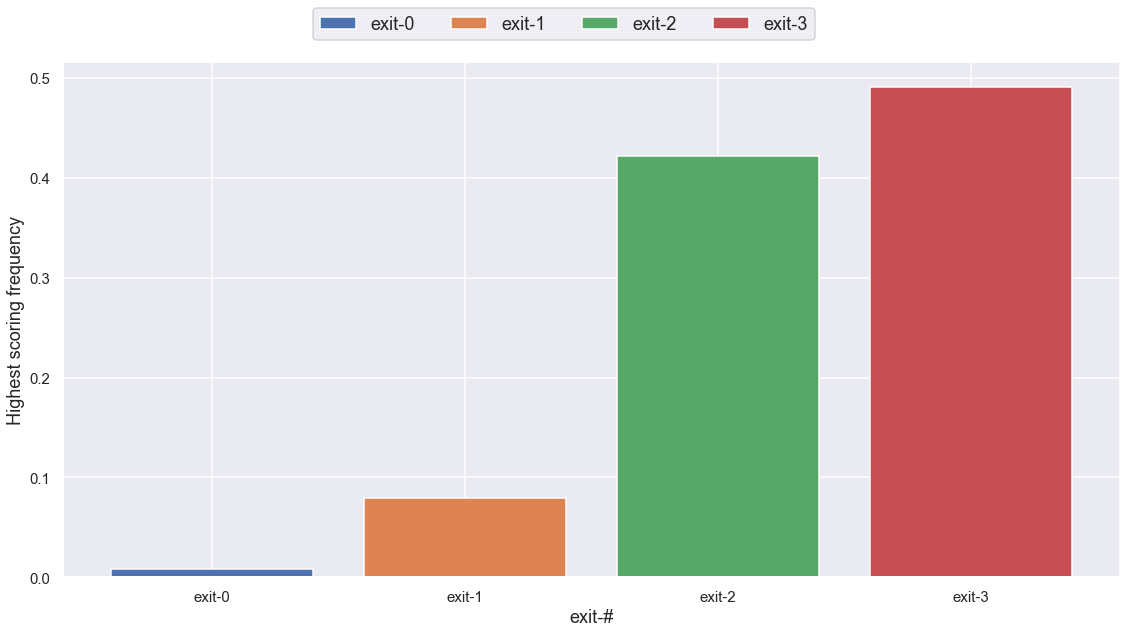

In [58]:
fig, ax = plt.subplots(1,1)
for i in range(4):
    ax.bar(i, exit_best[i] / 5000)

ax.set_xticks(np.arange(0,4,1))
ax.set_xticklabels(['exit-{}'.format(x) for x in range(4)])
ax.set(xlabel='exit-#', ylabel='Highest scoring frequency')

fig.legend(['exit-{}'.format(x) for x in range(4)], ncol=4, loc="upper center", fontsize='medium')
fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.savefig('highest-scoring.png')

In [21]:
match

4297

In [10]:
exit_stats = []
correct = np.zeros(len(data[0]))
for sample in data:
    for i, exit in enumerate(sample):
        correct[i] += exit['correct']
    
    
print(correct/len(data))

TypeError: string indices must be integers

In [ ]:
works_data = json_normalize(data=data)
works_data.head(3)